### Load Dependencies

In [311]:
import warnings
warnings.filterwarnings('ignore')

In [312]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

In [314]:
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

In [315]:
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

### Load Dataset

In [316]:
data=pd.read_csv('https://raw.githubusercontent.com/varun-pradhan-117/tweet-classification/main/datasets/tweets.csv')

In [317]:
#get stopword list
sw_list=stopwords.words('english')

#Since it might affect final outcome, a few words are removed from stopwords list
sw_list.remove('not')
sw_list.remove('no')
sw_list.remove('against')

In [318]:
#Initialize lemmatizer
lemmatizer=WordNetLemmatizer()

### Clean dataset

In [319]:
def nltk_wn_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:                    
    return None

In [320]:
def lemmatize_sentence(sentence):
    tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_wn_tag(x[1])), tagged)
    lemmatized_words=[]
    for word, tag in wordnet_tagged:
        if word not in sw_list:
            if tag is None:                        
                lemmatized_words.append(word)
            else:
                lemmatized_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_words)
    

In [321]:
def clean_tweets(tweet):
    #remove RT(retweet tag)
    tweet=re.sub(r"RT @","@",tweet)
    #remove pings
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    #remove URLs
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    #remove special characters
    tweet = re.sub(r"[^a-zA-Z]", ' ', tweet)
    #convert to lower case
    tweet=tweet.lower()
    #remove extra white spaces
    tweet = re.sub(r" +",' ', tweet)
    #lemmatization of tweet and removing stopwords
    lemmatized_tweet=lemmatize_sentence(tweet)
    #remove extra white spaces
    tweet = re.sub(r" +", ' ', tweet)
    return lemmatized_tweet.strip()

In [322]:
data['tweets']=[clean_tweets(tweet) for tweet in data['tweets']]

### Train Test Split

In [324]:
from sklearn.model_selection import train_test_split
X=data['tweets']
y=data['labels']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=7)

### sklearn/nltk processing

In [325]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect=TfidfVectorizer()
tfidf_vect.fit(X_train)
tfidf_dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

In [326]:
X_train_tfidf=tfidf_vect.transform(X_train).toarray()

In [327]:
list_of_tweets=[word_tokenize(tweet) for tweet in X_train]

In [329]:
from gensim.models import Word2Vec
w2v_model=Word2Vec(list_of_tweets,size=500)

In [330]:
w2v_model.vector_size

500

In [331]:
w2v_words = list(w2v_model.wv.vocab)

In [332]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vect.get_feature_names() 

tfidf_tweet_vectors = [];
row=0;
for tweet in list_of_tweets: 
    sent_vec = np.zeros(500) 
    weight_sum =0;
    for word in tweet: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = tfidf_dictionary[word]*(tweet.count(word)/len(tweet))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_tweet_vectors.append(sent_vec)
    row += 1

In [333]:
tfidf_test_vectors = [];
for tweet in [word_tokenize(tweet) for tweet in X_test]: 
    sent_vec = np.zeros(500) 
    weight_sum =0;
    for word in tweet: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = tfidf_dictionary[word]*(tweet.count(word)/len(tweet))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1

In [334]:
train_vectors=pd.DataFrame(tfidf_tweet_vectors)
test_vectors=pd.DataFrame(tfidf_test_vectors)

In [335]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [336]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train,3)

In [337]:
model=Sequential()
model.add(Dense(activation='relu',units=500))
model.add(Dropout(0.2))
model.add(Dense(activation='relu',units=32))
model.add(Dense(activation='softmax',units=3))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [338]:
history=model.fit(x=train_vectors,y=y_train,epochs=20)

Epoch 1/20
35/35 [==============================] - 1s 3ms/step - loss: 0.8193 - accuracy: 0.6838
Epoch 2/20
35/35 [==============================] - 0s 3ms/step - loss: 0.7834 - accuracy: 0.6911
Epoch 3/20
35/35 [==============================] - 0s 2ms/step - loss: 0.7781 - accuracy: 0.6911
Epoch 4/20
35/35 [==============================] - 0s 2ms/step - loss: 0.7775 - accuracy: 0.6911
Epoch 5/20
35/35 [==============================] - 0s 3ms/step - loss: 0.7782 - accuracy: 0.6911
Epoch 6/20
35/35 [==============================] - 0s 3ms/step - loss: 0.7771 - accuracy: 0.6911
Epoch 7/20
35/35 [==============================] - 0s 3ms/step - loss: 0.7713 - accuracy: 0.6911
Epoch 8/20
35/35 [==============================] - 0s 3ms/step - loss: 0.7758 - accuracy: 0.6911
Epoch 9/20
35/35 [==============================] - 0s 3ms/step - loss: 0.7714 - accuracy: 0.6911
Epoch 10/20
35/35 [==============================] - 0s 3ms/step - loss: 0.7746 - accuracy: 0.6911
Epoch 11/20
35/35 [

In [339]:
y_test=to_categorical(y_test,3)


In [340]:
y_predictions=(model.predict(test_vectors) > 0.5).astype("int32")

In [341]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [342]:
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       177
           1       0.00      0.00      0.00        80
           2       0.00      0.00      0.00        16

   micro avg       0.65      0.65      0.65       273
   macro avg       0.22      0.33      0.26       273
weighted avg       0.42      0.65      0.51       273
 samples avg       0.65      0.65      0.65       273



In [343]:
print(accuracy_score(y_test,y_predictions))

0.6483516483516484


In [344]:
confusion_matrix(y_test.argmax(axis=1),y_predictions.argmax(axis=1))

array([[177,   0,   0],
       [ 80,   0,   0],
       [ 16,   0,   0]])

In [345]:
losses=pd.DataFrame(history.history)

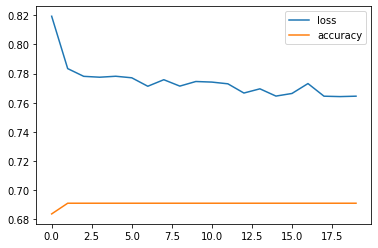

In [346]:
losses.plot()